In [1]:
%matplotlib inline

import time
import datetime

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from scipy.optimize import curve_fit
from jupyterthemes import jtplot

jtplot.style(theme='onedork')

In [2]:
# Data from:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [3]:
df = pd.read_csv(url, index_col=[0,1])
df

Lat       Long  \
Province/State              Country/Region                               
NaN                         Afghanistan            33.00000  65.000000   
                            Albania                41.15330  20.168300   
                            Algeria                28.03390   1.659600   
                            Andorra                42.50630   1.521800   
                            Angola                -11.20270  17.873900   
...                                                     ...        ...   
Falkland Islands (Malvinas) United Kingdom        -51.79630 -59.523600   
Saint Pierre and Miquelon   France                 46.88520 -56.315900   
NaN                         South Sudan             6.87700  31.307000   
                            Western Sahara         24.21550 -12.885800   
                            Sao Tome and Principe   0.18636   6.613081   

                                                   1/22/20  1/23/20  1/24/20  \
Province/State              Country/Region                                     
NaN                         Afghanistan                  0        0        0   
                            Albania                      0        0        0   
                            Algeria                      0        0        0   
                            Andorra                      0        0        0   
                            Angola                       0        0        0   
...                                                    ...      ...      ...   
Falkland Islands (Malvinas) United Kingdom               0        0        0   
Saint Pierre and Miquelon   France                       0        0        0   
NaN                         South Sudan                  0        0        0   
                            Western Sahara               0        0        0   
                            Sao Tome and Principe        0        0        0   

                                                   1/25/20  1/26/20  1/27/20  \
Province/State              Country/Region                                     
NaN                         Afghanistan                  0        0        0   
                            Albania                      0        0        0   
                            Algeria                      0        0        0   
                            Andorra                      0        0        0   
                            Angola                       0        0        0   
...                                                    ...      ...      ...   
Falkland Islands (Malvinas) United Kingdom               0        0        0   
Saint Pierre and Miquelon   France                       0        0        0   
NaN                         South Sudan                  0        0        0   
                            Western Sahara               0        0        0   
                            Sao Tome and Principe        0        0        0   

                                                   1/28/20  1/29/20  ...  \
Province/State              Country/Region                           ...   
NaN                         Afghanistan                  0        0  ...   
                            Albania                      0        0  ...   
                            Algeria                      0        0  ...   
                            Andorra                      0        0  ...   
                            Angola                       0        0  ...   
...                                                    ...      ...  ...   
Falkland Islands (Malvinas) United Kingdom               0        0  ...   
Saint Pierre and Miquelon   France                       0        0  ...   
NaN                         South Sudan                  0        0  ...   
                            Western Sahara               0        0  ...   
                            Sao Tome and Principe        0        0  ...   

                      

In [4]:
df2 = df.drop(['Lat', 'Long'], 1).groupby(level=1).sum().T
df2.index = pd.to_datetime(df2.index)
last_date = df2.index[-1]

df2

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-03,6,17,105,16,2,0,39,7,28,168,...,9,3611,4,2,7,0,1,0,1,1
2020-04-04,7,20,130,17,2,0,43,7,30,186,...,10,4320,5,2,7,0,1,0,1,1
2020-04-05,7,20,152,18,2,0,44,7,35,204,...,10,4943,5,2,7,0,1,0,1,1
2020-04-06,11,21,173,21,2,0,48,8,40,220,...,11,5385,6,2,7,0,1,0,1,1


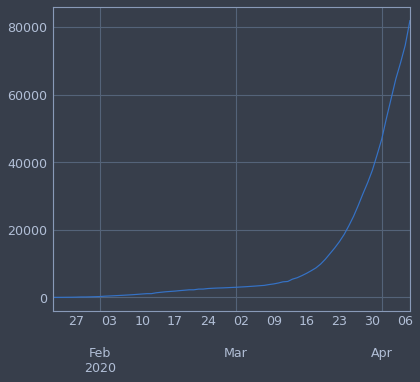

In [5]:
df2.T.sum().plot()

In [6]:
len(df2.columns)

184

In [7]:
df_exchina = df2.drop('China', 1)
df_exchina = df_exchina[df_exchina.T.sum() > 1]
len(df_exchina.columns)

183

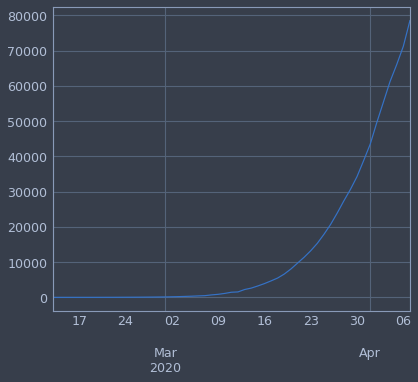

In [8]:
df_exchina.T.sum().plot()

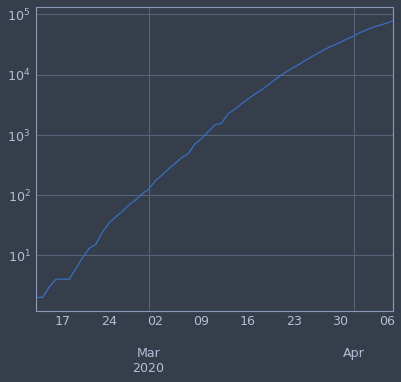

In [9]:
df_exchina.T.sum().plot(logy = True)

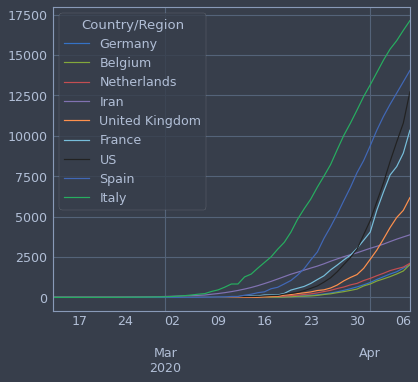

In [10]:
df_exchina.T.sort_values(by=last_date).tail(9).T.plot()

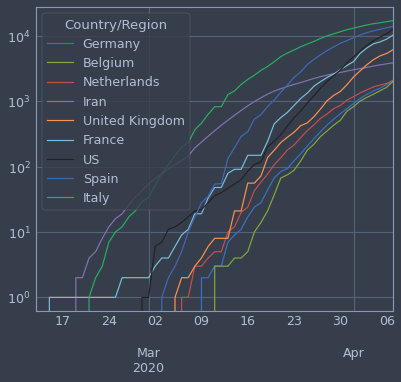

In [11]:
df_exchina.T.sort_values(by=last_date).tail(9).T.plot(logy = True)

In [12]:
df_exchina.T.sort_values(by=last_date).tail(9).T.tail(10)

Country/Region,Germany,Belgium,Netherlands,Iran,United Kingdom,France,US,Spain,Italy
2020-03-29,533,431,772,2640,1231,2611,2467,6803,10779
2020-03-30,645,513,865,2757,1411,3030,2978,7716,11591
2020-03-31,775,705,1040,2898,1793,3532,3873,8464,12428
2020-04-01,920,828,1175,3036,2357,4043,4757,9387,13155
2020-04-02,1107,1011,1341,3160,2926,5398,5926,10348,13915
2020-04-03,1275,1143,1490,3294,3611,6520,7087,11198,14681
2020-04-04,1444,1283,1656,3452,4320,7574,8407,11947,15362
2020-04-05,1584,1447,1771,3603,4943,8093,9619,12641,15887
2020-04-06,1810,1632,1874,3739,5385,8926,10783,13341,16523
2020-04-07,2016,2035,2108,3872,6171,10343,12722,14045,17127


In [13]:
df_exchina.T.sort_values(by=last_date).tail(9).T.diff().tail(10)

Country/Region,Germany,Belgium,Netherlands,Iran,United Kingdom,France,US,Spain,Italy
2020-03-29,100.0,78.0,132.0,123.0,210.0,294.0,441.0,821.0,756.0
2020-03-30,112.0,82.0,93.0,117.0,180.0,419.0,511.0,913.0,812.0
2020-03-31,130.0,192.0,175.0,141.0,382.0,502.0,895.0,748.0,837.0
2020-04-01,145.0,123.0,135.0,138.0,564.0,511.0,884.0,923.0,727.0
2020-04-02,187.0,183.0,166.0,124.0,569.0,1355.0,1169.0,961.0,760.0
2020-04-03,168.0,132.0,149.0,134.0,685.0,1122.0,1161.0,850.0,766.0
2020-04-04,169.0,140.0,166.0,158.0,709.0,1054.0,1320.0,749.0,681.0
2020-04-05,140.0,164.0,115.0,151.0,623.0,519.0,1212.0,694.0,525.0
2020-04-06,226.0,185.0,103.0,136.0,442.0,833.0,1164.0,700.0,636.0
2020-04-07,206.0,403.0,234.0,133.0,786.0,1417.0,1939.0,704.0,604.0


In [14]:
def sigmoid(x, sat, td, velo):
    x = np.float64(x)
    
    td *= 1e10
    td *= 1e9
    
    real_sat = 1e5 * sat
    x = x - td
    x /= 1e14
    return real_sat / (1 + np.exp(-x * velo))

x = df_exchina.index
sat = 30000 / 1e5
td = time.time() / 1e10
velo = .1

In [15]:
popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_exchina.index, 
                       ydata = df_exchina.T.sum(), 
                       p0 = (sat, td, velo)
                      )

In [16]:
y_fit = sigmoid(x, *list(popt))

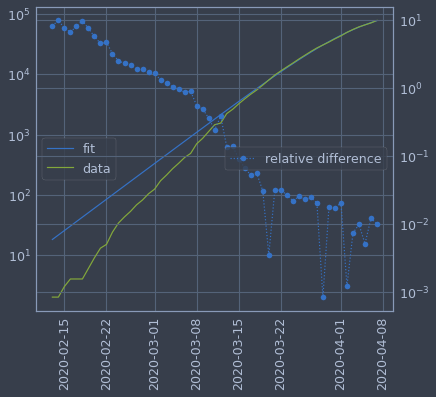

In [17]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)


ax1.semilogy(x, y_fit, label="fit")
ax1.semilogy(x, df_exchina.T.sum(), label="data")

ax2 = ax1.twinx()
ax2.semilogy(x, abs(y_fit - df_exchina.T.sum())/df_exchina.T.sum(), "o:", label="relative difference")
# ax1.legend(loc="lower left")
# ax2.legend(loc="center left")
ax1.legend(loc="center left")
ax2.legend(loc="center right")

In [18]:
th = datetime.datetime.fromtimestamp(popt[1] * 1e10)

In [19]:
f'The total number of Deaths outside China due to Covid-19 will be {int(popt[0] * 1e5)}. Half of those will be reached at {th.strftime("%Y-%B-%d %H:%M")}'

'The total number of Deaths outside China due to Covid-19 will be 134057. Half of those will be reached at 2020-April-05 04:42'

In [20]:
th - df_exchina.index[-1]

Timedelta('-2 days +04:42:56.014423')

In [21]:
df_exchina.T.sum().tail()

2020-04-03    55461
2020-04-04    61276
2020-04-05    66041
2020-04-06    71230
2020-04-07    78530
dtype: int64

In [28]:
df_exchina.T.sum().diff().tail(10)

2020-03-29    3268.0
2020-03-30    3653.0
2020-03-31    4524.0
2020-04-01    4695.0
2020-04-02    6168.0
2020-04-03    5800.0
2020-04-04    5815.0
2020-04-05    4765.0
2020-04-06    5189.0
2020-04-07    7300.0
dtype: float64

In [23]:
tstart = min(df_exchina.index)
tend = tstart + (th - tstart) * 2

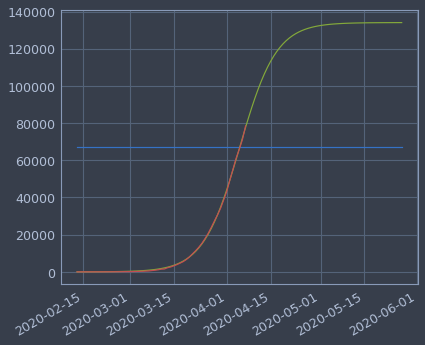

In [24]:
x_extra = np.arange(tstart, tend, datetime.timedelta(days=1)).astype('datetime64[ns]')
y_extra = sigmoid(x_extra, *list(popt))

plt.plot(x_extra, [popt[0]/2 * 1e5 for _ in x_extra])
plt.plot(x_extra, y_extra)
df_exchina.T.sum().plot()
plt.show()

In [25]:
x = []
y_var = []
y = []
h = []

for e in df_exchina.index[30:]:
    df_temp = df_exchina[:e]
    
    popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_temp.index, 
                       ydata = df_temp.T.sum(), 
                       p0 = (sat, td, velo)
                      )
    
    x.append(e + datetime.timedelta(days=1))
    y_var.append(np.diag(pcov)[1] * 1e10)
    y.append(datetime.datetime.fromtimestamp(popt[1] * 1e10))
    h.append(int(popt[0] * 1e5))
    

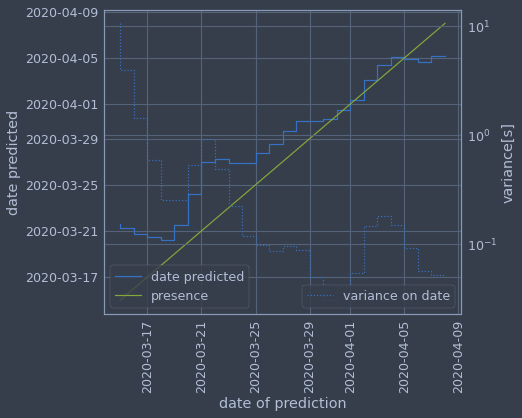

In [26]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)
plt.xlabel("date of prediction")

plt.ylabel("date predicted")

ax1.plot(x, y, label='date predicted', drawstyle='steps')
ax1.plot(x, x, label='presence')


ax2 = ax1.twinx()
ax2.semilogy(x, y_var, ":", label='variance on date', drawstyle='steps')
plt.ylabel("variance[s]")

ax1.legend(loc="lower left")
ax2.legend(loc="lower right")

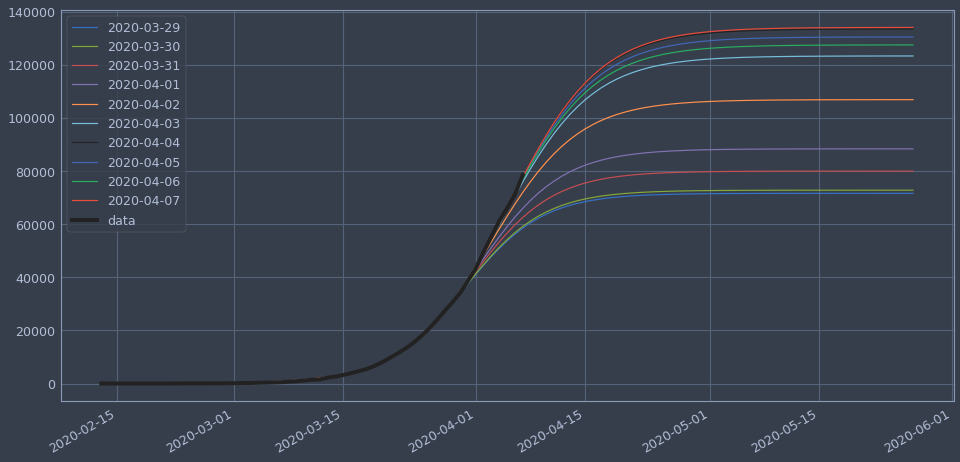

In [27]:
for e in df_exchina.index[-10:]:#[30:]:
    df_temp = df_exchina[:e]
    
    popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_temp.index, 
                       ydata = df_temp.T.sum(), 
                       p0 = (sat, td, velo)
                      )
    y_extra = sigmoid(x_extra, *list(popt))

    plt.plot(x_extra, y_extra, label=e.strftime("%Y-%m-%d"))
df_exchina.T.sum().plot(linewidth=4, style="k", label="data", figsize=(16,8))
plt.legend(loc="upper left")
plt.show()
    